In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from misc_funcs import get_samples
from dataset_specifications.dataset import LabelledData
from networks import NoiseInjection, FeedForward, DoubleInputNetwork 
from cgan_versions import PearsonCGAN, KLCGAN, RKLCGAN, WCGAN, WdivCGAN
from cgan import CGAN
import seaborn as sns
import pandas as pd
import evaluation as eval
import scipy.stats as ss
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler


plt.rcParams.update({'font.size': 13})
plt.rc("axes", labelsize=18)
plt.rc("axes", titlesize=21)
plt.rc("legend", fontsize=18)

2023-06-01 12:22:11.228645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 12:22:12.027324: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-01 12:22:12.027406: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-01 12:22:12.027417: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# Heteroskedastic
def mean_func(x):
    return np.power(x,2) + 0.5

def std_dev_func(x):
    return np.power(np.sin(np.pi*x), 2) + 0.01

def sample(xs =np.random.uniform(low=0., high=1., size=1000)):
    n = len(xs)
    assert n == len(xs), 'noise length should be same as xs length'
    noise = np.random.normal(loc=0., scale=std_dev_func(xs), size=n)
    ys = mean_func(xs) + noise

    return np.stack((xs, ys), axis=1)

# 1D Probability density functions as python function objects
def get_gaussian_pdf(mean, std_dev):
    dist = torch.distributions.normal.Normal(mean, std_dev)
    return (lambda y: torch.exp(dist.log_prob(y)))
def get_pdf(x):
    return get_gaussian_pdf(mean_func(x), std_dev_func(x))

def get_support(x):
    mean = mean_func(x)
    std_dev = std_dev_func(x)
    return (mean-2*std_dev, mean+2*std_dev)

In [3]:
# Sampling from heteroskedastic 
n = 2000 #number of samples
x_samples = np.random.uniform(low=0, high=1, size=n)
combined = sample(x_samples)

In [18]:
combined_train, combined_validation = model_selection.train_test_split(combined, test_size=0.5, random_state=43)

scaler = StandardScaler()
train_set_scaled = scaler.fit_transform(combined_train)
# Scale test data based on training data
val_set_scaled = scaler.transform(combined_validation)


# Test set for W evaluation
tmp = np.random.uniform(low=0, high=1, size=50)
tmp = np.sort(tmp, axis=0)
x_samples_test_repeated = np.repeat(tmp, repeats=200, axis = 0)
x_samples_test_repeated = x_samples_test_repeated.reshape((len(x_samples_test_repeated,)))
combined_test = sample(x_samples_test_repeated)
test_set_scaled = scaler.transform(combined_test)

In [19]:
# Make sure that heteroskedastic set from above corresponds to data imported below

#export data
DATASET_PATH = './datasets'
DATASET_NAME = 'heteroskedastic'

# preprocessing folder
raw_dataset_path = os.path.join(DATASET_PATH,DATASET_NAME,'raw_data')

if not os.path.exists(raw_dataset_path):
    os.makedirs(raw_dataset_path)


# raw data
np.savetxt("./{}/{}/raw_data/train.csv".format(DATASET_PATH,DATASET_NAME), combined_train,delimiter=",")
np.savetxt("./{}/{}/raw_data/val.csv".format(DATASET_PATH,DATASET_NAME), combined_validation,delimiter=",")
np.savetxt("./{}/{}/raw_data/test.csv".format(DATASET_PATH,DATASET_NAME), combined_test,delimiter=",")


np.savetxt("./{}/{}/train.csv".format(DATASET_PATH,DATASET_NAME), train_set_scaled,delimiter=",")
np.savetxt("./{}/{}/val.csv".format(DATASET_PATH,DATASET_NAME), val_set_scaled,delimiter=",")
np.savetxt("./{}/{}/test.csv".format(DATASET_PATH,DATASET_NAME), test_set_scaled,delimiter=",")

In [8]:
# tmp = np.random.choice(len(combined_validation),50, replace=False)
# x_samples_train_repeated = np.repeat(combined_train[tmp,:-1], repeats=200, axis = 0)
# x_samples_train_repeated = x_samples_train_repeated.reshape((len(x_samples_train_repeated,)))
# combined_train_repeated = sample(x_samples_train_repeated)
# train_set_repeated_scaled = scaler.transform(combined_train_repeated)
# np.savetxt("./{}/train_repeated.csv".format(raw_dataset_path), combined_train_repeated,delimiter=",")
# np.savetxt("./{}/{}/train_repeated.csv".format(DATASET_PATH,DATASET_NAME), train_set_repeated_scaled,delimiter=",")

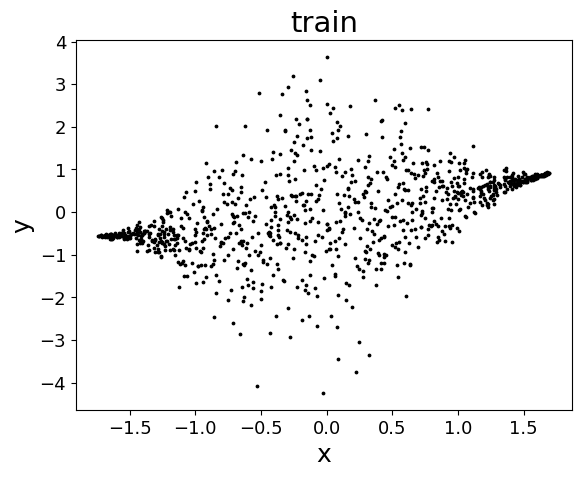

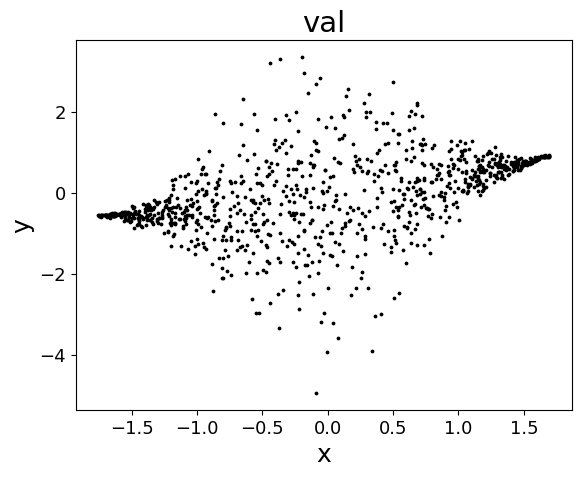

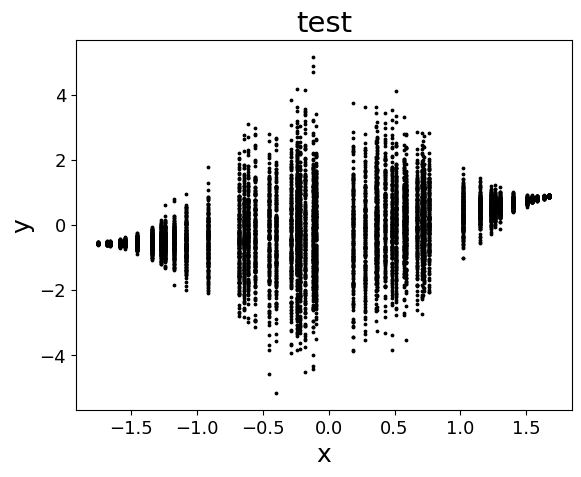

In [3]:
#import data
DATASET_PATH = './datasets'
DATASET_NAME = 'heteroskedastic'
dataset_dir = os.path.join(DATASET_PATH,DATASET_NAME)
assert os.path.exists(dataset_dir),("dataset folder {} does not exist".format(dataset_dir))

splits = {}
#CHANGE DIMENSIONS OF DATA ACCORDINGLY
X_DIM = 1
Y_DIM = 1
scatter_plot = 1

for split in ("train","val","test"):
    data_path = os.path.join(dataset_dir,"{}.csv".format(split))
    assert os.path.exists(data_path),"data file {} does not exist".format(data_path)
    
    data = np.genfromtxt(data_path,delimiter=",")
    if scatter_plot:
        plt.figure
        plt.scatter(data[:,:1],data[:,1:], c='k', s=3)
        plt.xlabel("x")
        plt.ylabel('y')
        plt.title(split)
        save_path = os.path.join("./plots", DATASET_NAME)
        plt.savefig('{}/{}.png'.format(save_path,split))
        plt.show()
        plt.close()
    torch_data = torch.tensor(data, device="cpu").float()
    splits[split] = LabelledData(x=torch_data[:,:X_DIM],y=torch_data[:,X_DIM:])

train_data = splits["train"]
val_data = splits['val']
test_data = splits['test']

In [4]:
def val_func(model, epoch):
    return eval.evaluate_model(model, data_val = val_data, data_train = train_data,
                                data_test = test_data, epoch = epoch)

In [5]:
# path for saving parameters of model
PARAM_PATH = './param_best'
FILE_NAME = 'heteroskedastic_CGAN'

# For saving plots
PLOT_PATH = './plots'
PLT_DATASET_NAME = 'heteroskedastic'


constants = {
    "dataset_path": DATASET_PATH,
    "dataset_name": DATASET_NAME,
    "plot_path": PLOT_PATH,
    "plt_dataset_name": PLT_DATASET_NAME,
    "param_path": PARAM_PATH,
    "file_name": FILE_NAME,
    "x_dim": X_DIM,
    "y_dim": Y_DIM
}

In [ ]:
# config for WCGAN
config = {
    "noise_dim": 5,
    "epochs": 5000,
    "batch_size": 200,
    "gen_lr": 3e-4,
    "disc_lr": 1e-4,
    "val_interval": 20,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.7,
    "pdf_index":None,
    "scatter": 1,
    "kde_batch_size": 15,
    "n_critic": 5,
    "lambda_gp": 2e-2,
    'one-sided': True
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": X_DIM,#conditioning data
    "nodes_per_layer": [64,64,64,64],
    "output_dim": Y_DIM,#fake data dimensions
    "activation": nn.ReLU(),
    "type": FeedForward,
    "dropout":None,
    "batch_norm": None,
    "activation_final": 0,
    "spectral_normalisation": None
},
'disc_spec': {
    "other_dim": Y_DIM,#actual data dimensions
    "cond_dim": X_DIM,
    "nodes_per_layer": [64,64,64,64],
    # "cond_layers": [64,64],
    # "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation": nn.ReLU(),
    "type": FeedForward,
    "dropout":None,
    "batch_norm": None,
    "activation_final": 0,
    "spectral_normalisation": None
}
}

cgan_model = WCGAN(config, nn_spec, constants)
cgan_model.train(train_data, val_data, test_data, val_func)

In [67]:
# tmp = test_data.x[-200:]
# tmp = tmp.repeat_interleave(2, dim=0)
# real = test_data.y[-200:]
# fake = cgan_model.sample(tmp)
# real_mean = torch.mean(real)
# import ot
# dist = ot.wasserstein_1d(real, fake, p = 1)/real_mean

/home/ylt/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch 19, true	ll: -1.6029	mae: 0.99801	Wasserstein-1 dist: 0.5929	Wasserstein-2 dist: 0.68793
Epoch 39, true	ll: -1.3171	mae: 0.62432	Wasserstein-1 dist: 0.18971	Wasserstein-2 dist: 0.37292
Epoch 59, true	ll: -1.3531	mae: 0.64615	Wasserstein-1 dist: 0.23308	Wasserstein-2 dist: 0.33219
Epoch 79, true	ll: -1.278	mae: 0.59791	Wasserstein-1 dist: 0.15103	Wasserstein-2 dist: 0.2303
Epoch 99, true	ll: -1.2082	mae: 0.59816	Wasserstein-1 dist: 0.10568	Wasserstein-2 dist: 0.19212
Epoch 119, true	ll: -1.1187	mae: 0.58593	Wasserstein-1 dist: 0.079044	Wasserstein-2 dist: 0.15627
Epoch 139, true	ll: -1.0803	mae: 0.58395	Wasserstein-1 dist: 0.093942	Wasserstein-2 dist: 0.16534
Epoch 159, true	ll: -1.0359	mae: 0.58944	Wasserstein-1 dist: 0.072958	Wasserstein-2 dist: 0.12387
Epoch 179, true	ll: -1.0132	mae: 0.59462	Wasserstein-1 dist: 0.058437	Wasserstein-2 dist: 0.1011
Epoch 199, true	ll: -0.99613	mae: 0.60044	Wasserstein-1 dist: 0.10334	Wasserstein-2 dist: 0.18744
Epoch 219, true	ll: -0.97807	mae: 

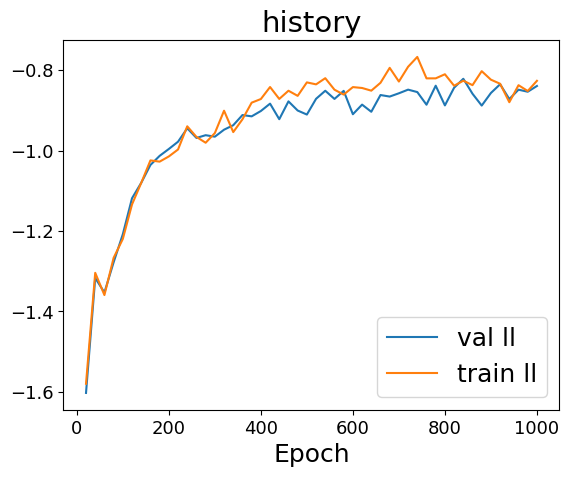

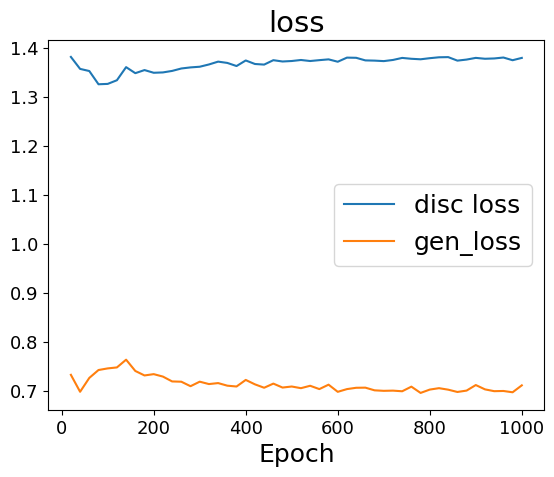

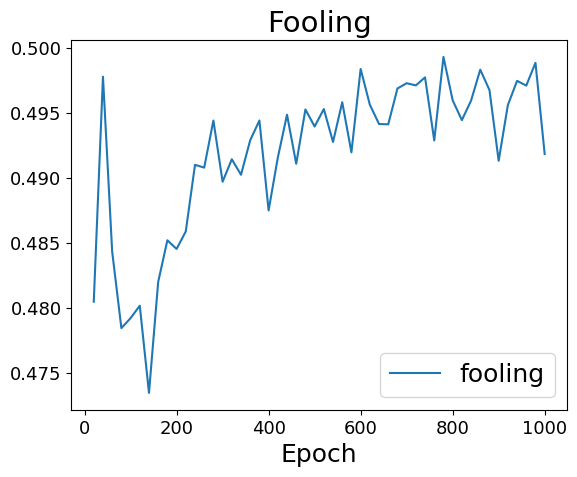

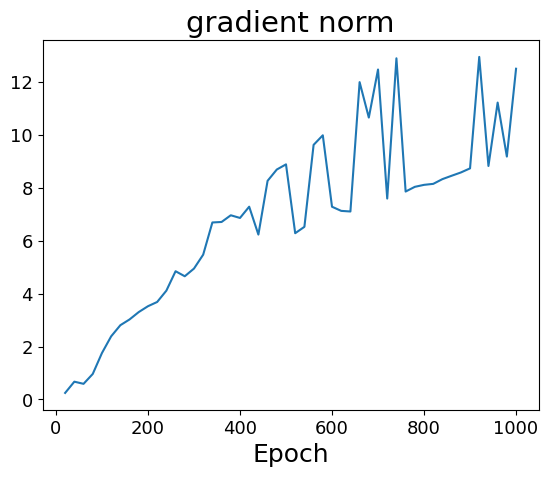

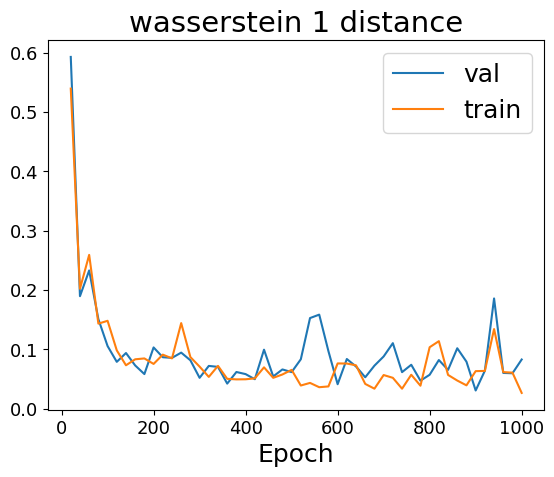

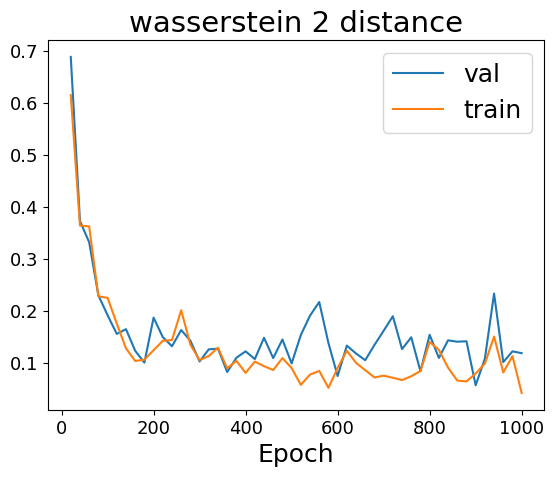

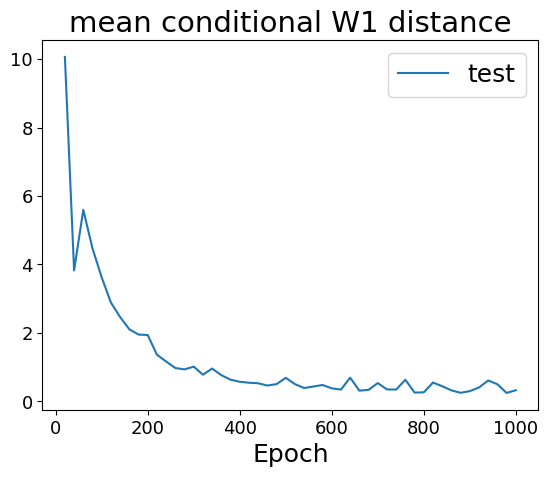

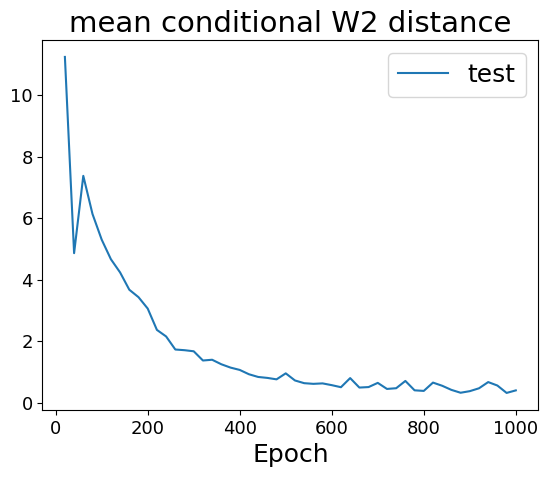

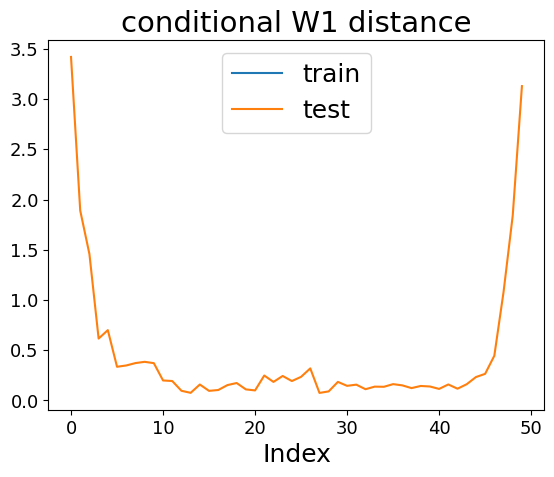

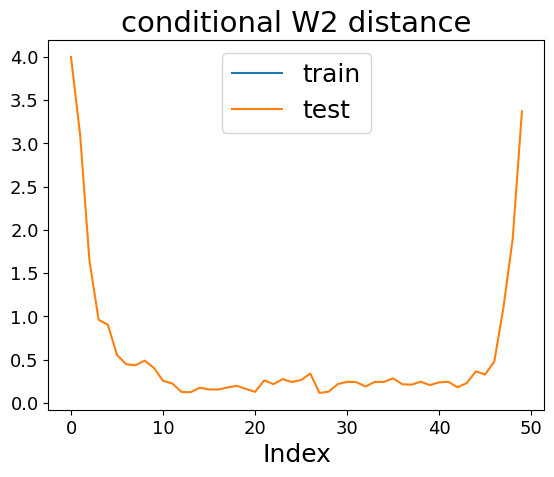

In [6]:
# #create nn spec for discriminator and generator
config = {
    "noise_dim": 5,
    "noise_dist": 'gaussian',
    "epochs": 1000,
    "batch_size": 200,
    "gen_lr": 1e-4,
    "disc_lr": 1e-4,
    "val_interval": 20,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.7,
    "pdf_index":0,
    "scatter": 1,
    "kde_batch_size": 10,
}

nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": X_DIM,#conditioning data
    "nodes_per_layer": [64, 64, 64, 64],
    "output_dim": Y_DIM,#fake data dimensions
    "activation": nn.ReLU(),
    "type": FeedForward,
    "dropout":None,
    "activation_final": 0,
    "spectral_normalisation": None,
    "batch_norm": None
},
'disc_spec': {
    "other_dim": Y_DIM,#actual data dimensions
    "cond_dim": X_DIM,
    "nodes_per_layer": [64,64,64,64],
    # "cond_layers": [64,64],
    # "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation": nn.ReLU(),
    "type": FeedForward,
    "dropout":None,
    "activation_final": 0,
    "spectral_normalisation": None,
    "batch_norm": None
}
}
cgan_model = CGAN(config, nn_spec, constants)
cgan_model.train(train_data, val_data, test_data, val_func)

In [7]:
## Comparsion between conditional pdf of real and generated samples
DATASET_PATH = './datasets'
DATASET_NAME = 'heteroskedastic'
raw_dataset_path = os.path.join(DATASET_PATH,DATASET_NAME,'raw_data')

for split in ('train','test','val'):
    data_path = os.path.join(raw_dataset_path,"{}.csv".format(split))
    assert os.path.exists(data_path),"data file {} does not exist".format(data_path)
    data = np.genfromtxt(data_path,delimiter=",")

    torch_data = torch.tensor(data, device="cpu").float()
    splits[split] = LabelledData(x=torch_data[:,:X_DIM],y=torch_data[:,X_DIM:])

train_data_raw = splits["train"]

y_train_mean = torch.mean(train_data_raw.y).item()
y_train_std = torch.std(train_data_raw.y).item()

x_train_std = torch.std(train_data_raw.x).item()
x_train_mean = torch.mean(train_data_raw.x).item()

In [8]:
best_save_path = os.path.join(cgan_model.param_dir,
                            "epoch_best.pt") # Path to save best params to
checkpoint = torch.load(best_save_path, map_location=cgan_model.device)
# checkpoint = torch.load(best_save_path)
if "gen" in checkpoint:
    cgan_model.gen.load_state_dict(checkpoint["gen"])
cgan_model.disc.load_state_dict(checkpoint["disc"])

<All keys matched successfully>

0.6534136384725571


Text(0.5, 1.0, 'x=0.5')

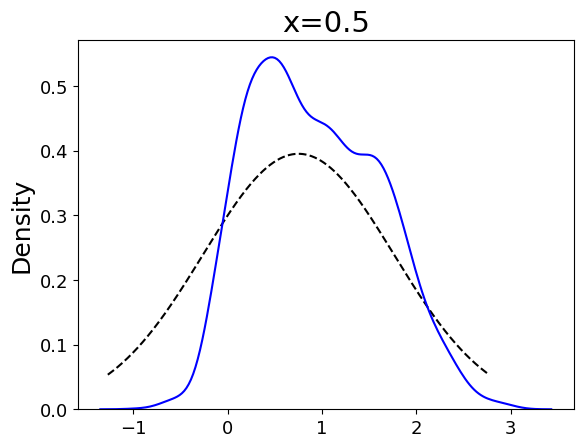

In [10]:
# generated samples
x0 = 0.5
print(x0*x_train_std+x_train_mean)
y_gen = get_samples(cgan_model,x0, num_samples=3000).numpy()
y_gen = y_gen*y_train_std+y_train_mean

# real pdf
real_pdf = get_pdf(x0)
supp = get_support(x0)
real_pdf_xs = torch.linspace(supp[0], supp[1], steps = 1000)
real_pdf_ys = real_pdf(real_pdf_xs)

plt.figure()
plt.plot(real_pdf_xs, real_pdf_ys, color ='k', linestyle='--',label='x={}'.format(x0))
sns.kdeplot(y_gen.squeeze(),color='b')
plt.title('x={}'.format(x0))

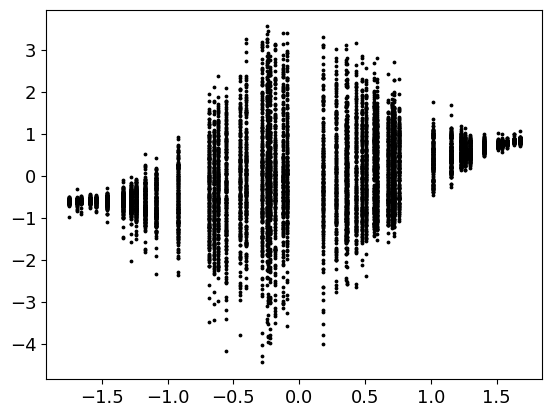

In [11]:
gen_samples = cgan_model.sample(test_data.x)
plt.scatter(test_data.x, gen_samples, s = 3, color ='k')


In [50]:
# tmp = checkpoint['gen']
# for key,_ in tmp.items():
#     print(key)

# print(len(tmp['layers.1.weight']))

Post-process

Text(0.5, 0, 'Epochs')

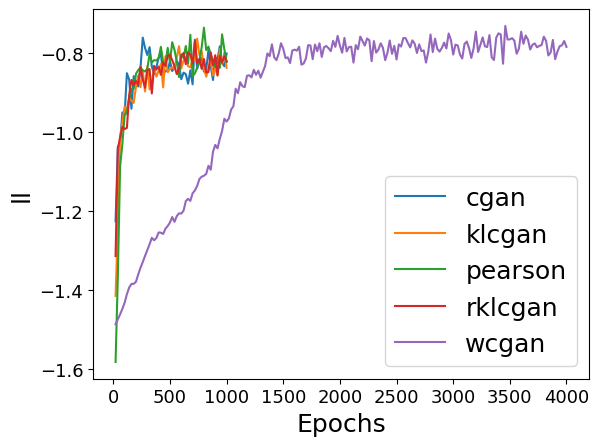

In [62]:
path = os.path.join('postprocess','heteroskedastic','ll.csv')
tmp = pd.read_csv(path, delimiter=',')
plt.figure()
for model in ('cgan', "klcgan", "pearson","rklcgan"):
    plt.plot(tmp['epoch'],tmp[model], label=model)
plt.plot(tmp['epoch.1'],tmp['wcgan'], label = 'wcgan')
plt.legend()
plt.ylabel("ll")
plt.xlabel('Epochs')
# plt.figure()
# plt.plot(tmp[:,0],tmp)